In [2]:
import pandas as pd
import numpy as np
import os
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm

#inport custom functions 
sys.path.append('../..')
import functions

In [3]:
sr = 22050     # sample rate. based on Nyquist frequency, we only care about frequencies up to 10kHz therefor the sample rate will only perserve those frequencies 
sample_rate = sr
n_fft = 2048
hop_length = 512
duration = 5 # length of song to be used (in seconds) 
n_mels=128
n_mfcc=40

In [4]:
audio_dataset_path = '/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original'
metadata= pd.read_csv('/Users/stephen/Flatiron/Phase4/MIR/Data/features_30_sec.csv')
metadata.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.350088,0.088757,0.130228,0.002827,1784.165850,129774.064525,2002.449060,85882.761315,...,52.420910,-1.690215,36.524071,-0.408979,41.597103,-2.303523,55.062923,1.221291,46.936035,blues
1,blues.00001.wav,661794,0.340914,0.094980,0.095948,0.002373,1530.176679,375850.073649,2039.036516,213843.755497,...,55.356403,-0.731125,60.314529,0.295073,48.120598,-0.283518,51.106190,0.531217,45.786282,blues
2,blues.00002.wav,661794,0.363637,0.085275,0.175570,0.002746,1552.811865,156467.643368,1747.702312,76254.192257,...,40.598766,-7.729093,47.639427,-1.816407,52.382141,-3.439720,46.639660,-2.231258,30.573025,blues
3,blues.00003.wav,661794,0.404785,0.093999,0.141093,0.006346,1070.106615,184355.942417,1596.412872,166441.494769,...,44.427753,-3.319597,50.206673,0.636965,37.319130,-0.619121,37.259739,-3.407448,31.949339,blues
4,blues.00004.wav,661794,0.308526,0.087841,0.091529,0.002303,1835.004266,343399.939274,1748.172116,88445.209036,...,86.099236,-5.454034,75.269707,-0.916874,53.613918,-4.404827,62.910812,-11.703234,55.195160,blues


In [5]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [6]:
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    try:
        final_class_labels=row["label"]
        file_name = os.path.join(os.path.abspath(audio_dataset_path), final_class_labels+'/',str(row["filename"]))    
        data=features_extractor(file_name)
        extracted_features.append([data,final_class_labels])
    except Exception as e:
        print(f"Error: {e}")
        continue

554it [00:20, 27.86it/s]/Users/stephen/opt/anaconda3/envs/torch_env/lib/python3.9/site-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")
557it [00:20, 23.00it/s]

Error: [Errno 2] No such file or directory: '/Users/stephen/Flatiron/Phase4/MIR/Data/genres_original/jazz/jazz.00054.wav'


1000it [00:35, 28.10it/s]


In [7]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-113.57065, 121.57179, -19.168142, 42.36642, ...",blues
1,"[-207.5017, 123.991264, 8.955127, 35.877647, 2...",blues
2,"[-90.722595, 140.4463, -29.09389, 31.684334, -...",blues
3,"[-199.5442, 150.0909, 5.6626782, 26.85908, 1.7...",blues
4,"[-160.3377, 126.219635, -35.58781, 22.148071, ...",blues


In [8]:
extracted_features_df['class'].value_counts()


blues        100
classical    100
country      100
disco        100
hiphop       100
metal        100
pop          100
reggae       100
rock         100
jazz          99
Name: class, dtype: int64

In [9]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [10]:
X.shape


(999, 40)

In [11]:
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [12]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [13]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(799, 40)
(200, 40)
(799, 10)
(200, 10)


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

y.shape[1]
### No of classes
num_labels=y.shape[1]

In [15]:
model=Sequential()
model.add(Dense(1024,input_shape=(40,), activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3))

###final layer
model.add(Dense(num_labels, activation="softmax"))

2021-11-17 11:30:56.516371: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [16]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              41984     
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               131328    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 128)               3

In [17]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [18]:
import time
t = time.localtime()
current_time = time.strftime("%H:%M:%S", t)

In [19]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath=f'saved_models/audio_classification_{current_time}.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

history = model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
24/25 [===========================>..] - ETA: 0s - loss: 4.8716 - accuracy: 0.1042
Epoch 00001: val_loss improved from inf to 2.26075, saving model to saved_models/audio_classification_11:30:56.hdf5
25/25 [==============================] - 1s 19ms/step - loss: 4.7975 - accuracy: 0.1014 - val_loss: 2.2607 - val_accuracy: 0.1350
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 2.5739 - accuracy: 0.1264
Epoch 00002: val_loss did not improve from 2.26075
25/25 [==============================] - 0s 8ms/step - loss: 2.5739 - accuracy: 0.1264 - val_loss: 2.2699 - val_accuracy: 0.1250
Epoch 3/100
22/25 [=========================>....] - ETA: 0s - loss: 2.4363 - accuracy: 0.1278
Epoch 00003: val_loss did not improve from 2.26075
25/25 [==============================] - 0s 8ms/step - loss: 2.4313 - accuracy: 0.1227 - val_loss: 2.2958 - val_accuracy: 0.1750
Epoch 4/100
18/25 [====================>.........] - ETA: 0s - loss: 2.3896 - accuracy: 0.1059
Epoch 00004: v

In [20]:
model.evaluate(X_test,y_test,verbose=0)

[1.5445315837860107, 0.6000000238418579]

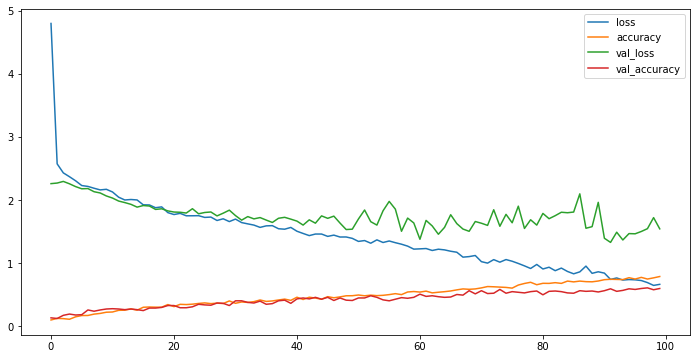

In [21]:
pd.DataFrame(history.history).plot(figsize=(12,6))
plt.show()